In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('btc.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [4]:
df = df.set_index('Timestamp')

In [5]:
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


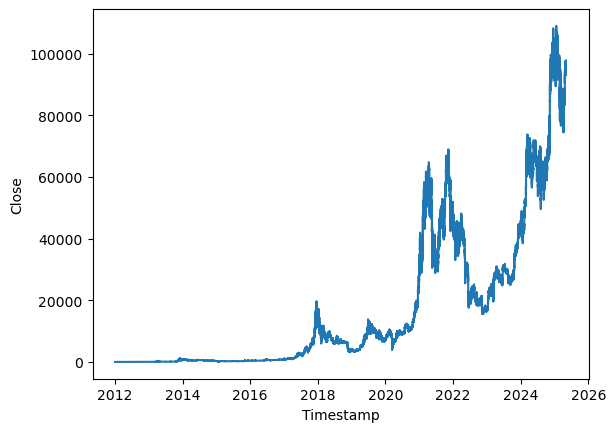

In [6]:
sns.lineplot(x=df.index, y=df['Close'])
plt.show()

In [7]:
df.tail()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-05-05 00:44:00,94682.0,94682.0,94682.0,94682.0,0.000000
2025-05-05 00:45:00,94690.0,94746.0,94690.0,94690.0,0.130246
2025-05-05 00:46:00,94726.0,94738.0,94725.0,94728.0,0.021155
2025-05-05 00:47:00,94734.0,94756.0,94734.0,94749.0,0.021390
2025-05-05 00:48:00,94750.0,94750.0,94709.0,94714.0,0.089986


In [8]:
# Resample to get day wise data
df = df.resample('D').first()

In [9]:
df

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.58,4.58,4.58,0.000000
2012-01-02,4.84,4.84,4.84,4.84,0.000000
2012-01-03,5.00,5.00,5.00,5.00,0.000000
2012-01-04,5.29,5.29,5.29,5.29,0.000000
2012-01-05,5.57,5.57,5.57,5.57,0.000000
...,...,...,...,...,...
2025-05-01,94181.00,94181.00,94141.00,94141.00,0.003797
2025-05-02,96557.00,96609.00,96557.00,96589.00,0.722763
2025-05-03,96926.00,96926.00,96910.00,96926.00,0.081145


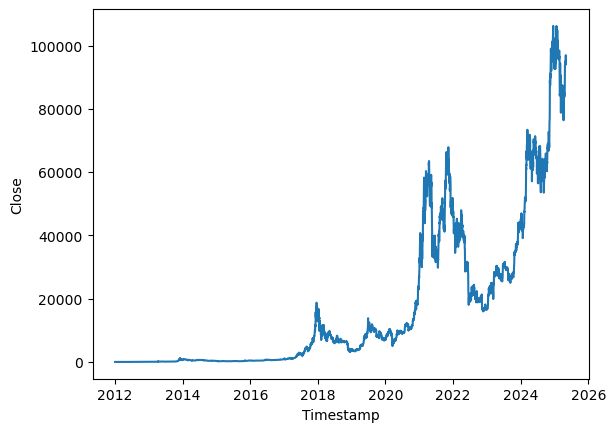

In [10]:
sns.lineplot(x=df.index, y=df['Close'])
plt.show()

### Check for Stationarity

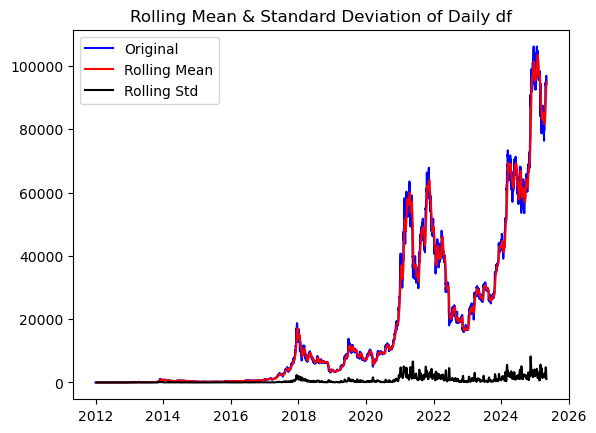

In [11]:
#Method 1: Rolling Statistics
rolmean = df['Close'].rolling(window=12).mean()
rolstd = df['Close'].rolling(window=12).std()

orig = plt.plot(df['Close'], color='blue', label = 'Original')
mean =plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.title('Rolling Mean & Standard Deviation of Daily df')
plt.legend()
plt.show()

In [12]:
# Method 2: Augumented Dicky Fuller Test

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close'])
result[1]

0.9666444141674304

In [13]:
print('P Value:',result[1])

P Value: 0.9666444141674304


The Time Series isn't stationary

Non stationary df to stationary df

In [14]:
# Differencing

diff = df['Close'] - df['Close'].shift(1)
diff

Timestamp
2012-01-01        NaN
2012-01-02       0.26
2012-01-03       0.16
2012-01-04       0.29
2012-01-05       0.28
               ...   
2025-05-01    -120.00
2025-05-02    2448.00
2025-05-03     337.00
2025-05-04   -1078.00
2025-05-05   -1585.00
Freq: D, Name: Close, Length: 4874, dtype: float64

In [15]:
diff.dropna(inplace=True)

In [16]:
result = adfuller(diff)
print('P-Value of ADF Test:',result[1])

P-Value of ADF Test: 1.5648270417111684e-16


you can confidently reject the null hypothesis, indicating that the time series is stationary.

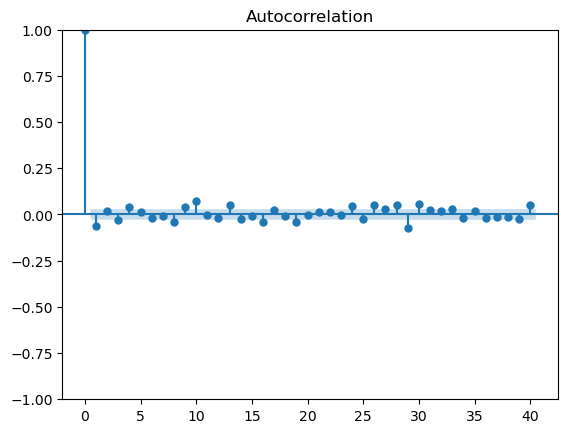

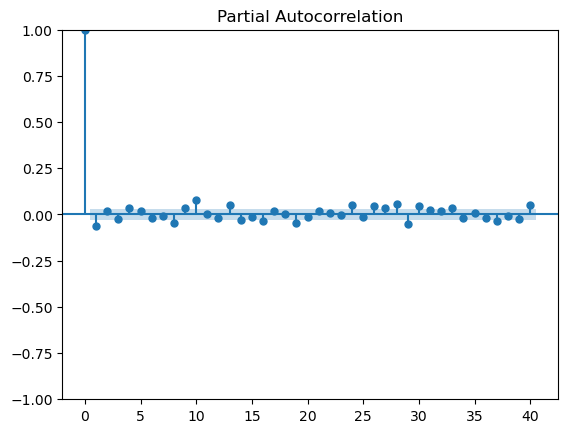

In [17]:
# Import autocorrelation and partial autocorrelation functions from statsmodels
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm

# Plot the autocorrelation function (ACF) for the differenced time series with 40 lags
fig = sm.graphics.tsa.plot_acf(diff, lags=40)
# Plot the partial autocorrelation function (PACF) for the differenced time series with 40 lags
fig = sm.graphics.tsa.plot_pacf(diff, lags=40)

## Train Test Split

In [18]:
train_size = int(len(df)*.80)
train_size

3899

In [19]:
train = diff[:3899]
test = diff[3899:]

## ARIMA

In [20]:
# Import the ARIMA model class from statsmodels time series analysis module
from statsmodels.tsa.arima.model import ARIMA

# Create an ARIMA model with parameters p=1 (autoregressive order), 
# d=1 (differencing order), and q=1 (moving average order)
model = ARIMA(diff, order=(1,1,1))
# Fit the ARIMA model to the differenced time series data
# Note: Variable name 'ARIMA' shadows the imported class name, which could be confusing
ARIMA = model.fit()

#### Prediction

In [21]:
# Generate predictions for the test dataset using the fitted SARIMAX model
# The prediction starts from the first index of test data and ends at the last index
ypred_test = ARIMA.predict(start=test.index[0], end = test.index[-1])

# Generate predictions for the training dataset using the fitted SARIMAX model
# This helps evaluate how well the model fits the training data
ypred_train = ARIMA.predict(start=train.index[0], end = train.index[-1])

#### Accuracy

In [22]:
from sklearn.metrics import r2_score

print('Train R2 of ARIMA:',r2_score(train, ypred_train))
print('Test R2 of ARIMA:',r2_score(test, ypred_test))

Train R2 of ARIMA: 0.0017093504412294402
Test R2 of ARIMA: 0.002968757425722557


## SARIMAX

In [23]:
# Import the SARIMAX model from statsmodels for time series analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model with parameters:
# - diff: the differenced time series data
# - seasonal_order=(1,1,1,12): specifies SARIMA components
#   - P=1: seasonal autoregressive order
#   - D=1: seasonal difference order
#   - Q=1: seasonal moving average order
#   - s=12: seasonal period (monthly seasonality)
model = SARIMAX(diff, seasonal_order=(1,1,1,12))

# Fit the model to the data and store the results
# Note: Variable name 'SARIMAX' overwrites the imported class name, which could cause issues
SARIMAX = model.fit()

#### Prediction

In [24]:
# Generate predictions for the test dataset using the fitted SARIMAX model
# The prediction starts from the first index of test data and ends at the last index
ypred_test = SARIMAX.predict(start=test.index[0], end=test.index[-1])

# Generate predictions for the training dataset using the fitted SARIMAX model
# This helps evaluate how well the model fits the training data
ypred_train = SARIMAX.predict(start=train.index[0], end=train.index[-1])

#### Accuracy

In [25]:
from sklearn.metrics import r2_score

print('Train R2 of SARIMAX Model:',r2_score(train, ypred_train))
print('Test R2 of SARIMAX Model:',r2_score(test, ypred_test))

Train R2 of SARIMAX Model: 0.0019919158104985124
Test R2 of SARIMAX Model: 0.0036107985699792566


## LSTM

#### Scaled the Data

In [26]:
# Import MinMaxScaler from sklearn's preprocessing module
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object to scale features to a range between 0 and 1
scaler = MinMaxScaler()
# Apply the scaler to the dataframe: first fit the scaler to the data, then transform it
# This scales all numerical features to the range [0,1]
scaled_data = scaler.fit_transform(df)

### Create Sequences

In [27]:
def create_sequences(data, seq_length, target_col_index):
    """
    Create sequences of data for time series prediction.
    
    Args:
        data: Scaled input data array
        seq_length: Number of time steps to use as input features
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Array of input sequences, shape (n_samples, seq_length, n_features)
        y: Array of target values, shape (n_samples,)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Create a sequence of length seq_length starting at position i
        X.append(data[i:i + seq_length])
        # Target is the value at position i + seq_length in the target column
        y.append(data[i + seq_length][target_col_index])
    return np.array(X), np.array(y)

# Set sequence length to 3 years of daily data (365*3 = 1095 days)
seq_length = 1095  # Using 1095 == 3 years to predict the next one
# Get the index of the 'Close' price column in the dataframe
target_col_index = df.columns.get_loc('Close')  # We predicting the 'Close' price

# Generate input sequences (X) and target values (y) for the model
X, y = create_sequences(scaled_data, seq_length, target_col_index)

#### Train Test Split

In [28]:
#80% 20% Split
split_index = int(0.8 *len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

#### LSTM Model

In [29]:
# Import necessary Keras modules for building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Create a Sequential model for time series prediction
model = Sequential([
    # First LSTM layer with 64 units, returning sequences for stacking LSTM layers
    # Input shape must match the training data dimensions (timesteps, features)
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    # Add dropout to prevent overfitting (20% of neurons will be randomly ignored during training)
    Dropout(0.2),
    # Second LSTM layer with 64 units, not returning sequences as it's the last LSTM layer
    LSTM(64),
    # Another dropout layer to further prevent overfitting
    Dropout(0.2),
    # Output layer with a single neuron for regression prediction
    Dense(1)
])

# Configure the model training process
# Using Adam optimizer and mean squared error loss function for regression
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 20 epochs with batches of 64 samples
# Validate performance on test data during training
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 667ms/step - loss: 0.0129 - val_loss: 0.0018
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 625ms/step - loss: 5.9500e-04 - val_loss: 0.0021
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 638ms/step - loss: 5.7513e-04 - val_loss: 0.0023
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 665ms/step - loss: 5.2455e-04 - val_loss: 0.0021
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 642ms/step - loss: 4.7252e-04 - val_loss: 9.2768e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - loss: 4.9781e-04 - val_loss: 0.0016
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 639ms/step - loss: 4.2488e-04 - val_loss: 0.0060
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - loss: 5.0407e-04 - val_loss: 0.0038
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 648ms/step - loss: 4.5813e-04 - val_loss: 0.0021
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 660ms/step - loss: 4.5229e-04 - val_loss: 6.7442e-04
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 647ms/step - loss: 4.6899e-04 - val_loss: 

#### Prediction

In [30]:
predicted = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step


In [31]:
# Reconstruct full data from inverted scaling
pad_pred = np.zeros((predicted.shape[0], scaled_data.shape[1]))  
# Create zero array with same width as original scaled data
pad_pred[:, target_col_index] = predicted[:,0]  
# Place predictions in the target column position
predicted_prices = scaler.inverse_transform(pad_pred)[:,target_col_index]  
# Inverse transform to get original scale and extract target column

#### Ploting - Actual Close Price vs Predicted Close Price

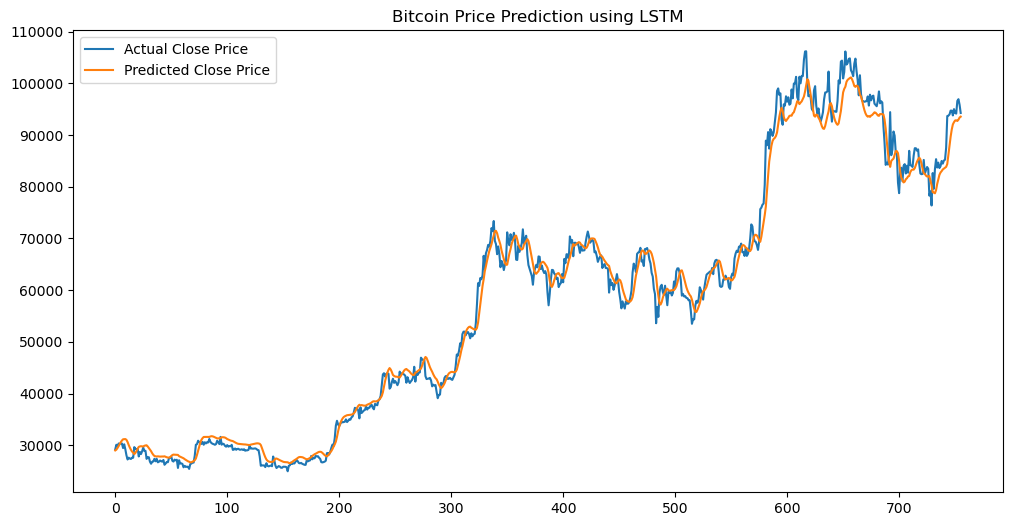

In [32]:
# Actual
actual_pad = np.zeros((y_test.shape[0], scaled_data.shape[1]))
actual_pad[:, target_col_index] = y_test
actual_prices = scaler.inverse_transform(actual_pad)[:, target_col_index]

# Step 8: Plot
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin Price Prediction using LSTM')
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 1930.36


In [34]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 2589.94


In [35]:
from sklearn.metrics import r2_score
print('Accuracy:',r2_score(actual_prices, predicted_prices))

Accuracy: 0.9888232674056162
